# pyfit demo

## Autograd engine

In [1]:
from pyfit.engine import Tensor

### Reverse-mode autodiff

In [2]:
x = Tensor(1.0)
z = 2 * x + 2 + x
q = z + z * x
h = z * z
y = h + q + q * x
print(y.data) # 45.0
y.backward()
print(x.grad) # 62.0 (the numerical value of dy/dx)

[[45.]]
[[62.]]


### Computation graph

In [3]:
# pip install graphviz
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    nodes, edges = trace(root)
    dot = Digraph(format='png')
    
    for n in nodes:
        dot.node(name=str(id(n)), label = f"{{ data {n.data} | grad {n.grad} }}", shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

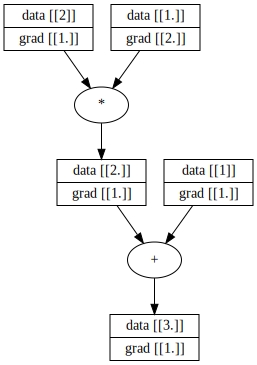

In [4]:
x = Tensor(1.0)
y = (x * 2 + 1)
y.backward()
draw_dot(y)

## Neural network API

### Single neuron

In [5]:
import random
from pyfit.nn import Neuron

random.seed(1337)
n = Neuron(2, activation='sigmoid')
print(n)
print(n.parameters())

<function sigmoid at 0x7f81b8073550> Neuron(2)
[Tensor(data=[[-0.53881021]
 [-0.82713213]], grad=[[0.]
 [0.]]), Tensor(data=[[-0.82982194]], grad=[[0.]])]


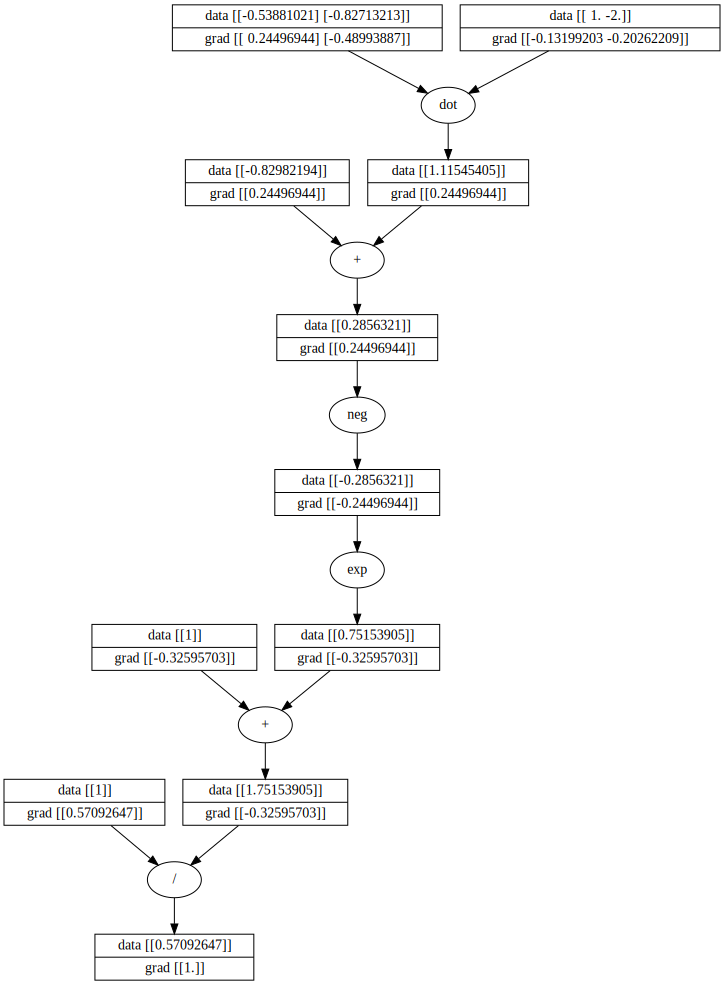

In [6]:
n.zero_grad()
x = Tensor([1.0, -2.0])
y = n(x)
y.backward()
draw_dot(y)

### Learning a line: y = 2 * x + 1

In [7]:
from pyfit.engine import Tensor
from pyfit.nn import Sequential, Dense
from pyfit.optim import SGD
from pyfit.loss import mean_squared_error
from pyfit.train import Trainer
from pyfit.data import BatchIterator

inputs = Tensor([[x] for x in range(10)])
targets = Tensor([[2*x+1] for x in range(10)])

n = Neuron(1, activation='linear')
optimizer = SGD(n.parameters(), learning_rate=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    epoch_loss = 0
    for i in range(10):
        output = n(inputs[i])
        loss = mean_squared_error(output, targets[i])
        epoch_loss += loss.data[0, 0]
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"epoch: {epoch}, loss: {epoch_loss}, w: {n.w.data[0,0]}, b: {n.b.data[0,0]}")

epoch: 0, loss: 161.21957847915016, w: 1.2857078056787092, b: 2.1014429264130907
epoch: 10, loss: 0.04758793294729726, w: 1.980277377174365, b: 1.0728345456116697
epoch: 20, loss: 8.054830980655515e-05, w: 1.9991886201710847, b: 1.0029964595209402
epoch: 30, loss: 1.3632906339221447e-07, w: 1.9999666197015111, b: 1.000123274833481
epoch: 40, loss: 2.3073871489102592e-10, w: 1.9999986267290755, b: 1.0000050715467566
epoch: 50, loss: 3.9052828304075037e-13, w: 1.9999999435034104, b: 1.0000002086442603
epoch: 60, loss: 6.609743025671934e-16, w: 1.9999999976757208, b: 1.0000000085836591
epoch: 70, loss: 1.1187090329213568e-18, w: 1.9999999999043783, b: 1.0000000003531324
epoch: 80, loss: 1.8938846708866464e-21, w: 1.9999999999960654, b: 1.0000000000145282
epoch: 90, loss: 3.20178288817854e-24, w: 1.9999999999998375, b: 1.0000000000005977


### Learning XOR

In [8]:
inputs = Tensor([[0, 0], [0, 1], [1, 0], [1, 1]])
targets = Tensor([[0], [1], [1], [0]])

print(inputs.shape)
print(targets.shape)

(4, 2)
(4, 1)


In [9]:
model = Sequential()
model.add(Dense(2, 4, activation='sigmoid'))
model.add(Dense(4, 1, activation='sigmoid'))
print(model)
print(f"Number of parameters: {len(model.parameters())}")

MLP of [Layer of <function sigmoid at 0x7f81b8073550> Neurons(2), Layer of <function sigmoid at 0x7f81b8073550> Neurons(4)]
Number of parameters: 4


In [10]:
optimizer = SGD(model.parameters(), learning_rate=0.01)
loss = mean_squared_error
batch = BatchIterator(inputs, targets, batch_size=4, shuffle=True)

trainer = Trainer(model, optimizer, loss)
_ = trainer.fit(batch, num_epochs=100, verbose=True)

model(inputs)

ValueError: non-broadcastable output operand with shape (4,1) doesn't match the broadcast shape (4,4)